<a href="https://colab.research.google.com/github/jerryorajekwe/Predicting-Loan-Default-Risk-with-Machine-Learning-Models/blob/main/loandefaultworkings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loan Default Prediction Model**
This script is designed to predict loan defaults using machine learning models. It includes steps for:

1. Data preprocessing, including handling missing values, encoding categorical features, and dealing with outliers.
2. Resampling to address class imbalance using SMOTE.
3. Training and hyperparameter tuning for Logistic Regression, Random Forest, and XGBoost models.
4. Evaluating the models using metrics such as ROC-AUC,Accuracy, Precision, Recall, and F1-Score.
5. Visualizing feature importances and interpreting model results.
The goal is to identify the most effective model for predicting loan defaults while gaining insights from the data.

# **1. Setup**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Libraries**

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for preprocessing and imputation
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

# Libraries for model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import ConfusionMatrixDisplay

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# For handling imbalanced data
from imblearn.over_sampling import SMOTE

# Additional utilities
from collections import Counter

# **3. Data loading and sampling**

In [3]:
# Load the dataset
loan_data = pd.read_csv('/content/drive/MyDrive/loan.csv', low_memory=False)

In [4]:
# 30% random sample
loan_data_sample = loan_data.sample(frac=0.3, random_state=42)

In [5]:
# Save the sampled dataset
loan_data_sample.to_csv('loan_data_sample.csv', index=False)

# **4. Dataset Overview**

In [6]:
# Display information about the sampled dataset
print("Sampled Dataset Information:")
loan_data_sample.info()

Sampled Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 678200 entries, 1758049 to 2038627
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 755.4+ MB


In [7]:
print("First 5 Rows of the Dataset:")
loan_data_sample.head()

First 5 Rows of the Dataset:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
1758049,NaN,NaN,35000,35000,35000.0,36 months,12.12,1164.51,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
686533,NaN,NaN,30000,30000,30000.0,60 months,10.75,648.54,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
900721,NaN,NaN,15000,15000,15000.0,36 months,7.49,466.53,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1727912,NaN,NaN,24000,24000,24000.0,60 months,21.15,651.31,E,E2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
539691,NaN,NaN,14400,14400,14400.0,36 months,8.59,455.18,A,A5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print("Table 1: Descriptive Statistics:")
loan_data_sample.describe().round(2)

Table 1: Descriptive Statistics:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,url,dti,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,0.0,678200.00,678200.00,678200.00,678200.00,678200.00,678199.00,0.0,677684.00,...,3120.0,3120.00,3120.0,3120.00,2484.00,3120.00,3120.00,9997.00,9997.00,9997.00
mean,NaN,NaN,15063.79,15058.51,15040.42,13.10,446.30,77946.48,NaN,18.85,...,3.0,151.33,3.0,13.77,444.48,11385.30,194.32,5028.51,47.83,13.09
std,NaN,NaN,9189.32,9187.32,9191.01,4.83,267.19,74649.50,NaN,14.53,...,0.0,125.54,0.0,9.75,366.31,7421.83,201.58,3699.03,7.13,8.07
min,NaN,NaN,500.00,500.00,0.00,5.31,15.69,0.00,NaN,-1.00,...,3.0,1.61,3.0,0.00,10.17,193.98,0.01,107.00,0.45,0.00
25%,NaN,NaN,8000.00,8000.00,8000.00,9.49,251.98,46000.00,NaN,11.91,...,3.0,57.76,3.0,5.00,171.97,5531.34,43.69,2240.75,45.00,6.00
50%,NaN,NaN,13000.00,13000.00,12875.00,12.62,378.59,65000.00,NaN,17.85,...,3.0,116.40,3.0,15.00,344.52,9919.18,128.99,4179.00,45.00,14.00
75%,NaN,NaN,20000.00,20000.00,20000.00,15.99,593.82,93000.00,NaN,24.50,...,3.0,208.74,3.0,23.00,609.23,15698.72,286.32,6831.00,50.00,18.00
max,NaN,NaN,40000.00,40000.00,40000.00,30.99,1717.63,10999200.00,NaN,999.00,...,3.0,893.63,3.0,31.00,2680.89,40149.35,1275.36,30000.00,184.36,50.00


In [9]:
# Get all features
features = loan_data_sample.columns.tolist()
print("All Features:", features)

# Separate numerical and categorical features
numerical_features = loan_data_sample.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = loan_data_sample.select_dtypes(include=['object']).columns.tolist()

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

All Features: ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il

# **5. Data Prepocessing**

**5.1 Drop unnecessary columns**

In [10]:
columns_to_drop = [
    # IDs & Metadata
    'id', 'member_id', 'url', 'desc', 'title', 'zip_code', 'addr_state',

    # Loan Application Details
    'policy_code', 'pymnt_plan', 'hardship_flag', 'debt_settlement_flag',

    # Hardship & Settlement Details
    'hardship_type', 'hardship_reason', 'hardship_status',
    'hardship_start_date', 'hardship_end_date', 'hardship_loan_status',
    'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
    'settlement_amount', 'settlement_percentage', 'settlement_term',

    # Payment History & Unnecessary Dates
    'next_pymnt_d', 'last_credit_pull_d', 'issue_d', 'earliest_cr_line',

    # Extra Financial Metrics
    'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'collection_recovery_fee',

    # Redundant Features
    'total_pymnt_inv', 'total_rec_int', 'recoveries'
]

# Drop the columns
loan_data_sample = loan_data_sample.drop(columns=columns_to_drop)

# Save the cleaned dataset
loan_data_sample.to_csv('loan_data_cleaned.csv', index=False)

print("Successfully dropped unnecessary columns and saved cleaned dataset!")

Successfully dropped unnecessary columns and saved cleaned dataset!


In [11]:
# Display information about the cleaned dataset
print("Cleaned Dataset Information:")
loan_data_sample.info()

Cleaned Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 678200 entries, 1758049 to 2038627
Columns: 111 entries, loan_amnt to disbursement_method
dtypes: float64(92), int64(3), object(16)
memory usage: 579.5+ MB


**5.2 Check for duplicates**

In [12]:
# Number of duplicate records
loan_data_sample.duplicated().sum()

np.int64(0)

**5.3 Check for missing values**

In [13]:
# Missing values in each column
loan_data_sample.isnull().sum()

,0
loan_amnt,0
funded_amnt,0
funded_amnt_inv,0
term,0
int_rate,0
...,...
hardship_dpd,675080
orig_projected_additional_accrued_interest,675716
hardship_payoff_balance_amount,675080
hardship_last_payment_amount,675080


**5.4 Handle missing values**

In [14]:
# Drop columns with high missing values
threshold = 0.5
columns_to_drop = loan_data_sample.columns[loan_data_sample.isnull().mean() > threshold]
loan_data_sample = loan_data_sample.drop(columns=columns_to_drop)

print(f"Dropped columns: {list(columns_to_drop)}")

Dropped columns: ['mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'deferral_term', 'hardship_amount', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount']


In [15]:
# Identify numerical and categorical features
num_features = loan_data_sample.select_dtypes(include=['float64', 'int64']).columns
cat_features = loan_data_sample.select_dtypes(include=['object']).columns

# Apply median imputation for numerical features
num_imputer = SimpleImputer(strategy='median')
loan_data_sample[num_features] = num_imputer.fit_transform(loan_data_sample[num_features])

# Apply mode imputation for categorical features
cat_imputer = SimpleImputer(strategy='most_frequent')
loan_data_sample[cat_features] = cat_imputer.fit_transform(loan_data_sample[cat_features])

print("Successfully handled missing values across all features!")

Successfully handled missing values across all features!


**5.5 Verify whether all missing values have been succesfully handled**

In [16]:
loan_data_sample.isnull().sum().sum()

np.int64(0)

# **6. Exploratory Data Analysis**

**6.1 Numerical Feature analysis**

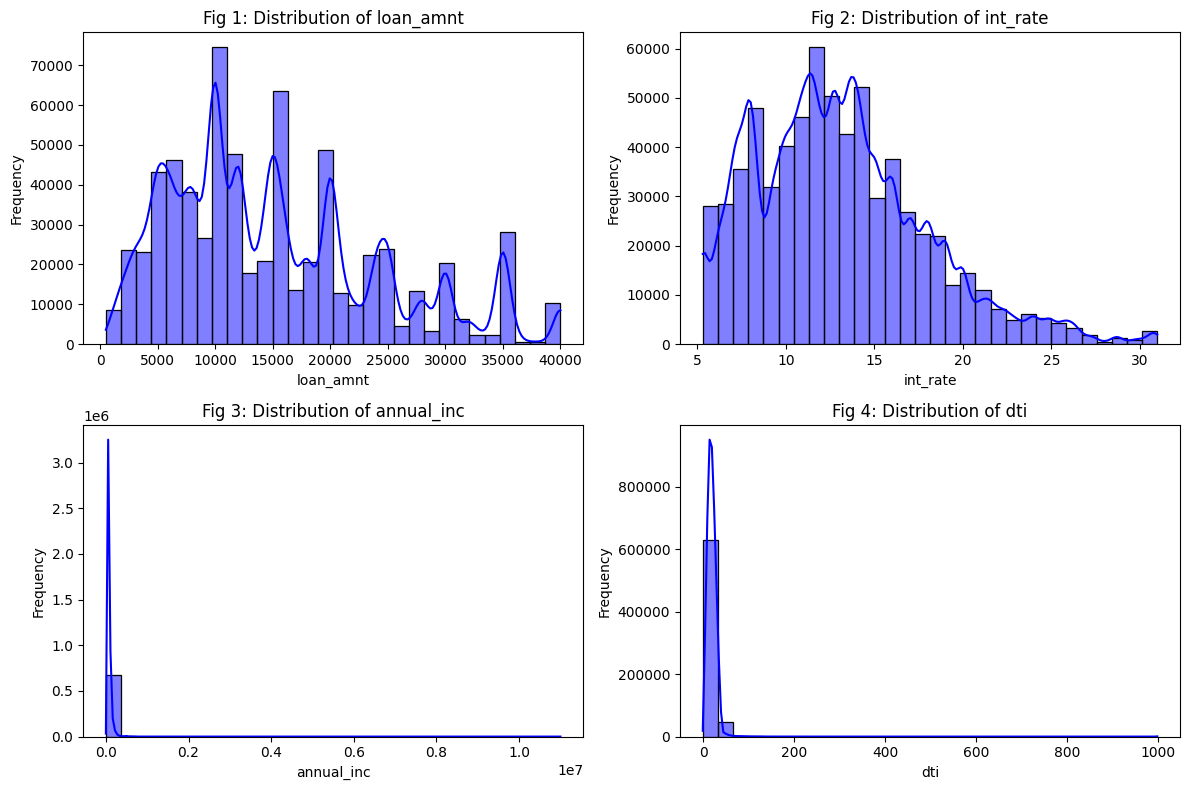

In [17]:
# List of numerical variables to analyze
num_vars = ['loan_amnt', 'int_rate', 'annual_inc', 'dti']

# Plot histograms with figure labels
plt.figure(figsize=(12, 8))
for i, var in enumerate(num_vars, 1):
    plt.subplot(2, 2, i)  # Create subplots
    sns.histplot(loan_data_sample[var], kde=True, bins=30, color='blue')
    plt.title(f'Fig {i}: Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**6.2 Categorical Feature Analysis**

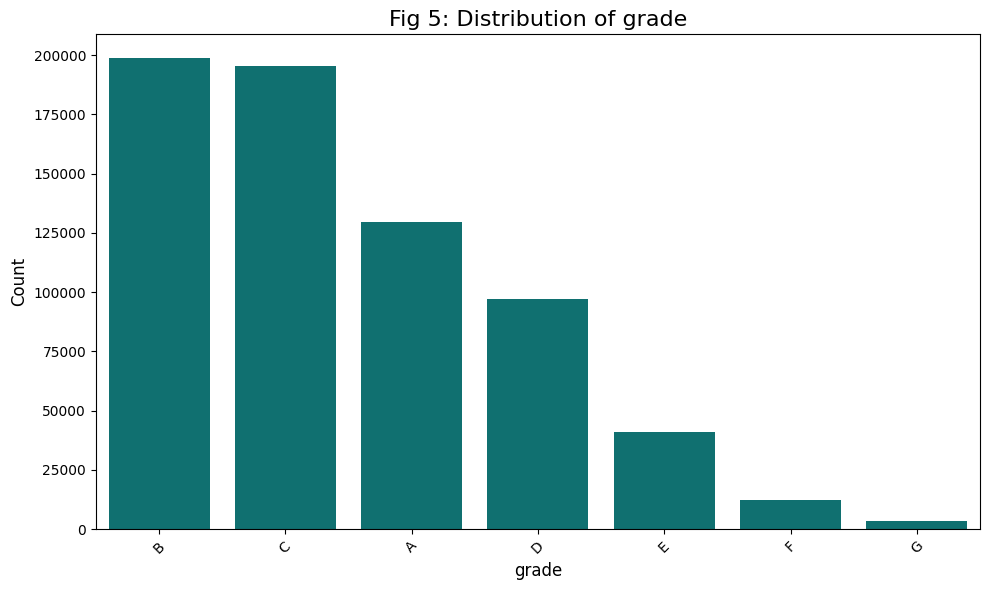

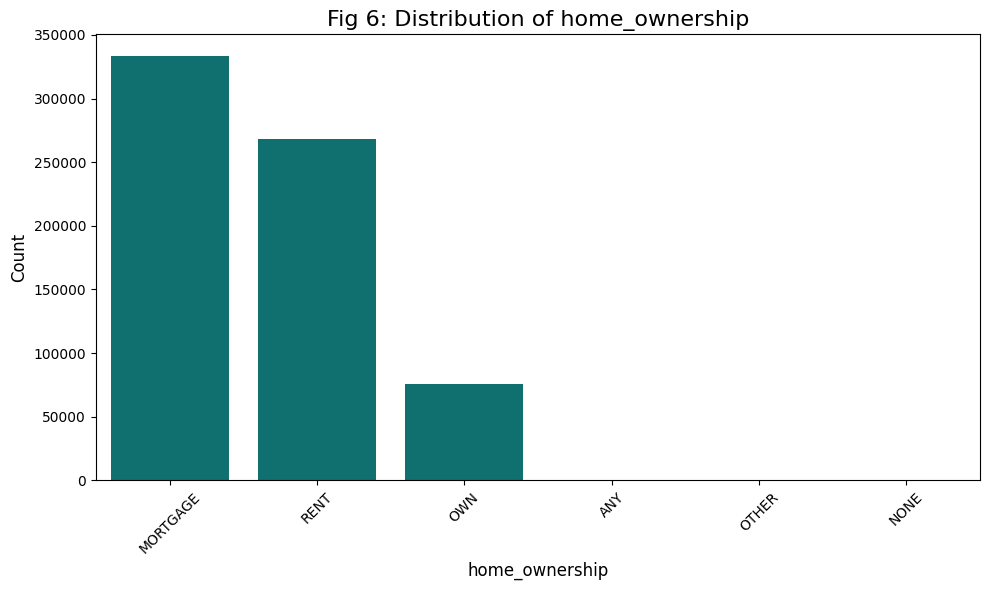

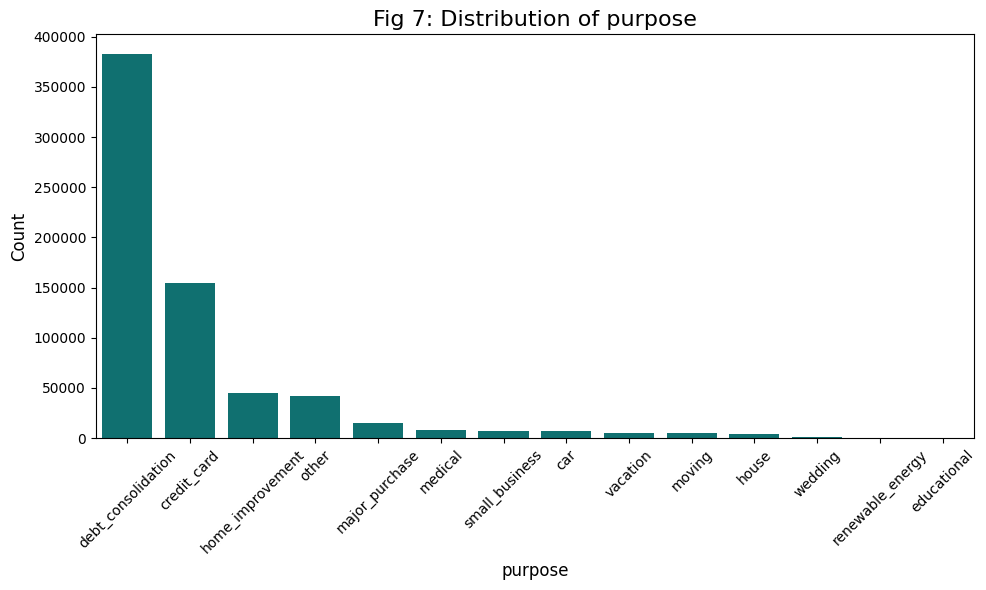

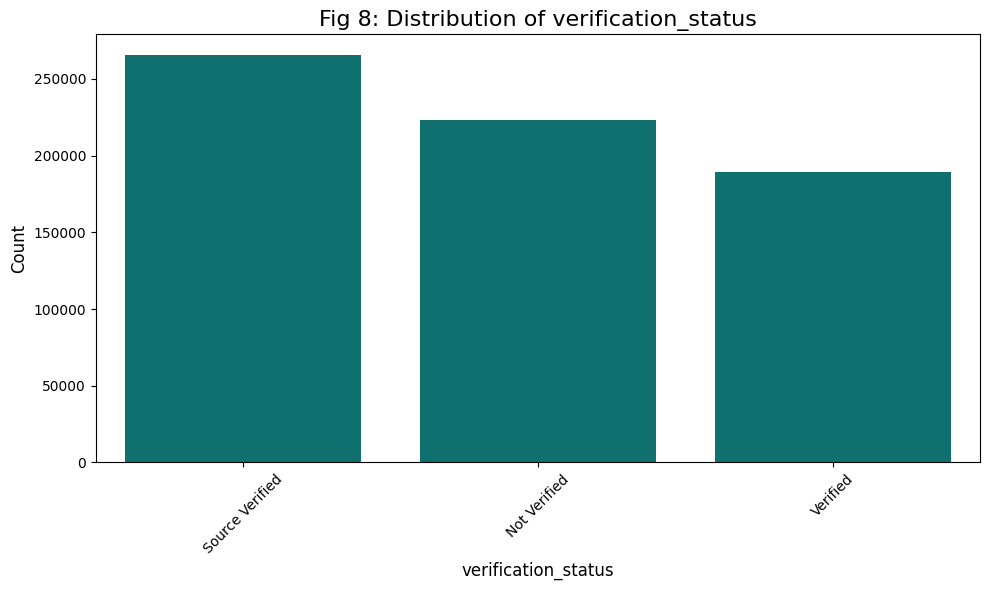

In [18]:
# List of categorical features to analyze
categorical_vars = ['grade', 'home_ownership', 'purpose', 'verification_status']

# Plot distributions of each categorical feature
for i, var in enumerate(categorical_vars, start=5):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=loan_data_sample, x=var, color='teal', order=loan_data_sample[var].value_counts().index)
    plt.title(f"Fig {i}: Distribution of {var}", fontsize=16)
    plt.xlabel(var, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

**6.3 Target variable analysis**

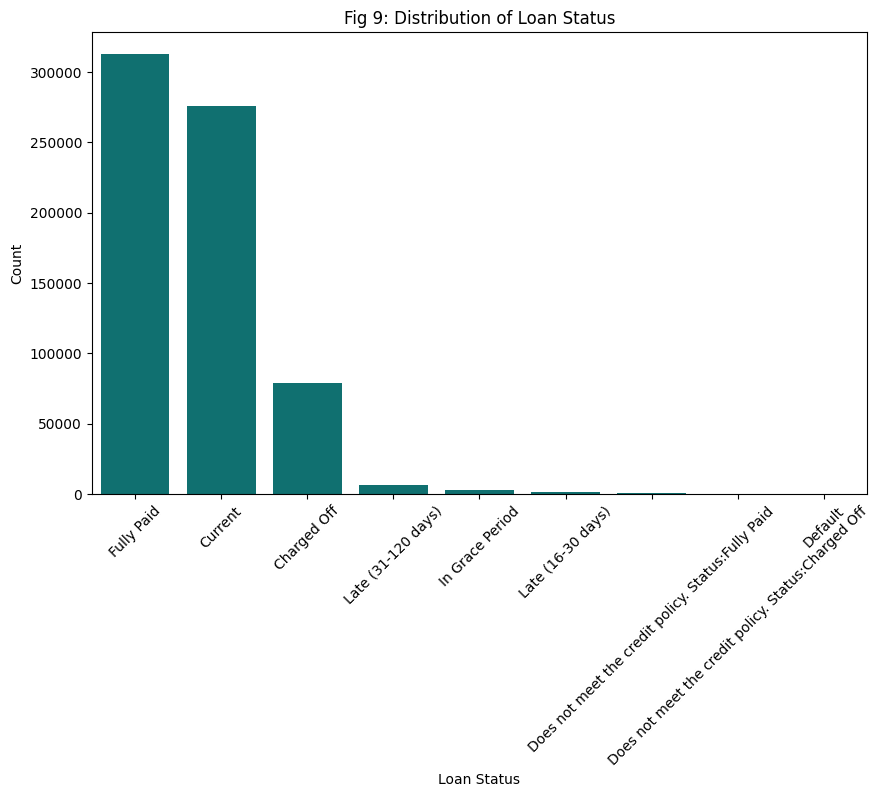

In [19]:
# Visualize loan_status distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=loan_data_sample, x='loan_status', order=loan_data_sample['loan_status'].value_counts().index, color='teal')
plt.title("Fig 9: Distribution of Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# **7. Dropping highly correlated features**

In [20]:
# Compute correlation matrix
corr_matrix = loan_data_sample.select_dtypes(include=['number']).corr().abs()

# Identify highly correlated features (threshold > 0.85)
threshold = 0.85
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > threshold:
            high_corr_pairs.append((corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Convert the results into a DataFrame for tabular display
high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
print("Highly Correlated Features (Before Dropping):")
print(high_corr_df)

Highly Correlated Features (Before Dropping):
                     Feature 1          Feature 2  Correlation
0                  funded_amnt          loan_amnt     0.999748
1              funded_amnt_inv          loan_amnt     0.999050
2              funded_amnt_inv        funded_amnt     0.999364
3                  installment          loan_amnt     0.945463
4                  installment        funded_amnt     0.945815
5                  installment    funded_amnt_inv     0.944987
6              total_rec_prncp        total_pymnt     0.966859
7          num_rev_tl_bal_gt_0    num_actv_rev_tl     0.983496
8                     num_sats           open_acc     0.990064
9              tot_hi_cred_lim        tot_cur_bal     0.975327
10  total_il_high_credit_limit  total_bal_ex_mort     0.872276


In [21]:
# Drop the highly correlated features
high_corr_features = set(high_corr_df["Feature 1"])  # Remove one feature from each pair
loan_data_sample = loan_data_sample.drop(columns=high_corr_features)

print(f"Removed highly correlated features: {high_corr_features}")

Removed highly correlated features: {'total_rec_prncp', 'num_rev_tl_bal_gt_0', 'num_sats', 'total_il_high_credit_limit', 'funded_amnt', 'installment', 'funded_amnt_inv', 'tot_hi_cred_lim'}


# **8. Binarize the target variable**

In [22]:
# Simplify loan_status into two categories: Default (0) and Non-Default (1), then drop the original column
loan_data_sample['loan_status_binary'] = loan_data_sample['loan_status'].map({
    'Fully Paid': 1,
    'Current': 1,
    'Charged Off': 0,
    'Default': 0,
    'Late (31-120 days)': 0,
    'Late (16-30 days)': 0,
    'In Grace Period': 0,
    'Does not meet the credit policy. Status:Fully Paid': 1,
    'Does not meet the credit policy. Status:Charged Off': 0
})

loan_data_sample.drop(columns=['loan_status'], inplace=True)

# Check the mapping and confirm changes
print("Loan status successfully binarized!")
print(loan_data_sample['loan_status_binary'].value_counts())

Loan status successfully binarized!
loan_status_binary
1    588786
0     89414
Name: count, dtype: int64


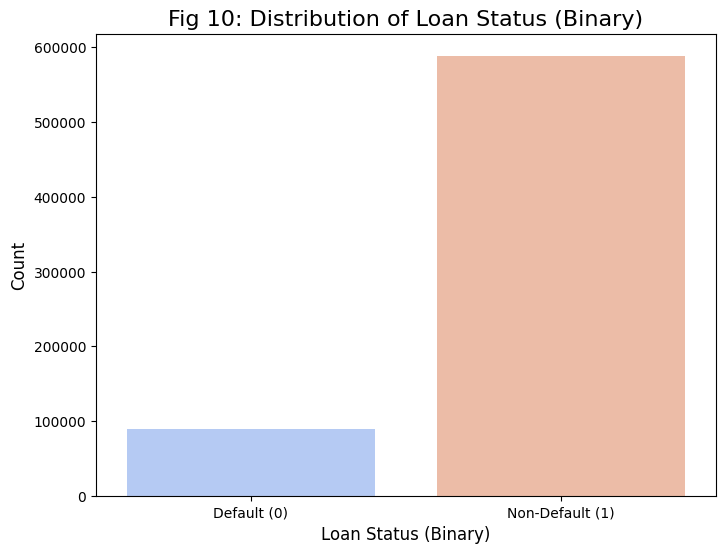

In [23]:
# Plot the distribution of loan_status_binary
plt.figure(figsize=(8, 6))
sns.countplot(data=loan_data_sample, x='loan_status_binary', palette='coolwarm')
plt.title("Fig 10: Distribution of Loan Status (Binary)", fontsize=16)
plt.xlabel("Loan Status (Binary)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Default (0)', 'Non-Default (1)'], fontsize=10)
plt.show()

# **9. Outliers**

In [24]:
def cap_outliers_and_fillna(df, columns):
    for col in columns:
        lower_cap = df[col].quantile(0.01)  # 1st percentile
        upper_cap = df[col].quantile(0.99)  # 99th percentile
        df[col] = df[col].clip(lower=lower_cap, upper=upper_cap)  # Capping values

    df[columns] = df[columns].fillna(df[columns].median())

    return df

# Apply outlier capping
num_features = loan_data_sample.select_dtypes(include=['float64', 'int64']).columns
loan_data_sample = cap_outliers_and_fillna(loan_data_sample, num_features)

print("Ouliers successfully handled!")

Ouliers successfully handled!


# **10. Train-test Split**

In [25]:
# Separate features (X) and target (y)
X = loan_data_sample.drop(columns=['loan_status_binary'])
y = loan_data_sample['loan_status_binary']

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the shape of the splits
print(f"Training Data Shape: {X_train.shape}, {y_train.shape}")
print(f"Testing Data Shape: {X_test.shape}, {y_test.shape}")

Training Data Shape: (542560, 75), (542560,)
Testing Data Shape: (135640, 75), (135640,)


# **11. Encoding Categorical Features**

In [26]:
# Identify categorical columns
cat_features = X_train.select_dtypes(include=['object']).columns

# Initialize Ordinal Encoder (handles unseen categories)
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit encoder on training data and transform
X_train[cat_features] = ordinal_encoder.fit_transform(X_train[cat_features])

# Apply encoding to test set
X_test[cat_features] = ordinal_encoder.transform(X_test[cat_features])

print(f"Encoded all categorical features. New Data Shape: {loan_data_sample.shape}")

Encoded all categorical features. New Data Shape: (678200, 76)


# **12. Feature Scaling**

In [27]:
# Identify numerical columns
num_features = X_train.select_dtypes(include=['float64', 'int64']).columns

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform training data
X_train[num_features] = scaler.fit_transform(X_train[num_features])

# Transform test data (keeping consistency)
X_test[num_features] = scaler.transform(X_test[num_features])

print("Successfully scaled numerical features!")


Successfully scaled numerical features!


# **13. Addressing class imbalance using SMOTE**

In [28]:
# Check the class distribution before SMOTE
print(f"Class distribution before SMOTE: {Counter(y_train)}")

# Apply SMOTE only to the training set (avoid data leakage)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print(f"Class distribution after SMOTE: {Counter(y_train_resampled)}")

Class distribution before SMOTE: Counter({1: 470872, 0: 71688})
Class distribution after SMOTE: Counter({1: 470872, 0: 470872})


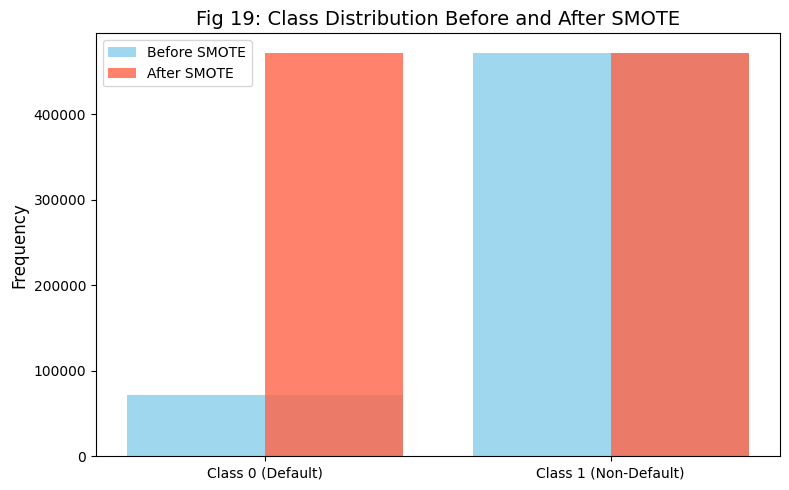

In [29]:
# Distributions for visualization
before_dist = Counter(y_train)
after_dist = Counter(y_train_resampled)

# Bar plot
plt.figure(figsize=(8, 5))
labels = ['Class 0 (Default)', 'Class 1 (Non-Default)']

# Plot before SMOTE
plt.bar(labels, [before_dist[0], before_dist[1]], color='skyblue', alpha=0.8, label='Before SMOTE')

# Plot after SMOTE
plt.bar(labels, [after_dist[0], after_dist[1]], color='tomato', alpha=0.8, label='After SMOTE', width=0.4, align='edge')

plt.title("Fig 19: Class Distribution Before and After SMOTE", fontsize=14)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# **14. Model training and evaluation**

**14.1 Logistic Regression**

In [30]:
# Train Logistic Regression model
lr_baseline = LogisticRegression(random_state=42, max_iter=100)
lr_baseline.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_lr = lr_baseline.predict(X_test)
y_prob_lr = lr_baseline.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (1)

# Evaluate the model
print("🔹 Logistic Regression Evaluation Metrics:")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_lr):.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))


print("Classification Report:")
print(classification_report(y_test, y_pred_lr))


🔹 Logistic Regression Evaluation Metrics:
ROC-AUC Score: 0.8865
Confusion Matrix:
[[14221  3505]
 [25043 92871]]
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.80      0.50     17726
           1       0.96      0.79      0.87    117914

    accuracy                           0.79    135640
   macro avg       0.66      0.79      0.68    135640
weighted avg       0.89      0.79      0.82    135640



**14.2 Random Forest**

In [31]:
# Train Random Forest model
rf_baseline = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=5)
rf_baseline.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_rf = rf_baseline.predict(X_test)
y_prob_rf = rf_baseline.predict_proba(X_test)[:, 1]

# Evaluate the model
print("🔹 Random Forest Evaluation Metrics:")
print(f"\n ROC-AUC Score: {roc_auc_score(y_test, y_prob_rf):.4f}\n")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\n Classification Report:")
print(classification_report(y_test, y_pred_rf))

🔹 Random Forest Evaluation Metrics:

 ROC-AUC Score: 0.8768

Confusion Matrix:
[[13221  4505]
 [20497 97417]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.75      0.51     17726
           1       0.96      0.83      0.89    117914

    accuracy                           0.82    135640
   macro avg       0.67      0.79      0.70    135640
weighted avg       0.88      0.82      0.84    135640



**14.3 Xgboost**

In [32]:
# Train XGBoost model
xgb_baseline = XGBClassifier(random_state=42, n_estimators=50, max_depth=3, eval_metric='logloss')  # Lower depth
xgb_baseline.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_xgb = xgb_baseline.predict(X_test)
y_prob_xgb = xgb_baseline.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (1)

# Evaluate the model
print("🔹 XGBoost Evaluation Metrics:")
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_prob_xgb):.4f}\n")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))


🔹 XGBoost Evaluation Metrics:

ROC-AUC Score: 0.9836

Confusion Matrix:
[[ 16142   1584]
 [  1591 116323]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     17726
           1       0.99      0.99      0.99    117914

    accuracy                           0.98    135640
   macro avg       0.95      0.95      0.95    135640
weighted avg       0.98      0.98      0.98    135640



# **15. Hyperparameter Tuning**

In [33]:
# Define optimized hyperparameter grids
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 300]
}

param_grid_rf = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_xgb = {
    'n_estimators': [100, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'subsample': [0.8, 1.0]
}

# Initialize models
lr_model = LogisticRegression(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

# Perform Randomized Search for each model
random_search_lr = RandomizedSearchCV(lr_model, param_grid_lr, cv=3, scoring='accuracy', n_iter=5, n_jobs=-1, random_state=42)
random_search_rf = RandomizedSearchCV(rf_model, param_grid_rf, cv=3, scoring='accuracy', n_iter=5, n_jobs=-1, random_state=42)
random_search_xgb = RandomizedSearchCV(xgb_model, param_grid_xgb, cv=3, scoring='accuracy', n_iter=5, n_jobs=-1, random_state=42)

# Fit models
random_search_lr.fit(X_train_resampled, y_train_resampled)
random_search_rf.fit(X_train_resampled, y_train_resampled)
random_search_xgb.fit(X_train_resampled, y_train_resampled)

# Print best hyperparameters
print("✅ Best Logistic Regression Hyperparameters:", random_search_lr.best_params_)
print("✅ Best Random Forest Hyperparameters:", random_search_rf.best_params_)
print("✅ Best XGBoost Hyperparameters:", random_search_xgb.best_params_)

✅ Best Logistic Regression Hyperparameters: {'solver': 'liblinear', 'max_iter': 300, 'C': 10}
✅ Best Random Forest Hyperparameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20}
✅ Best XGBoost Hyperparameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1}


In [34]:
# Check if the models have been trained successfully
print("✅ Randomized Search Logistic Regression Best Estimator:", random_search_lr.best_estimator_)
print("✅ Randomized Search Random Forest Best Estimator:", random_search_rf.best_estimator_)
print("✅ Randomized Search XGBoost Best Estimator:", random_search_xgb.best_estimator_)

✅ Randomized Search Logistic Regression Best Estimator: LogisticRegression(C=10, max_iter=300, random_state=42, solver='liblinear')
✅ Randomized Search Random Forest Best Estimator: RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=300,
                       random_state=42)
✅ Randomized Search XGBoost Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=

In [35]:
# Make predictions using best estimators
y_pred_lr_best = random_search_lr.best_estimator_.predict(X_test)
y_pred_rf_best = random_search_rf.best_estimator_.predict(X_test)
y_pred_xgb_best = random_search_xgb.best_estimator_.predict(X_test)

**15.1 Logistic Regression**

In [36]:
# Logistic Regression Evaluation
print("\n🔹 LR Accuracy Score:", accuracy_score(y_test, y_pred_lr_best))
print("\n🔹 Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr_best))
print("\n🔹 Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr_best))


🔹 LR Accuracy Score: 0.7895974638749631

🔹 Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.80      0.50     17726
           1       0.96      0.79      0.87    117914

    accuracy                           0.79    135640
   macro avg       0.66      0.79      0.68    135640
weighted avg       0.89      0.79      0.82    135640


🔹 Logistic Regression Confusion Matrix:
 [[14221  3505]
 [25034 92880]]


**15.2 Random Forest**

In [37]:
# Random Forest Evaluation
print("\n🔹 RF Accuracy Score:", accuracy_score(y_test, y_pred_rf_best))
print("\n🔹 Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf_best))
print("\n🔹 Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_best))


🔹 RF Accuracy Score: 0.9513344146269537

🔹 Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82     17726
           1       0.98      0.97      0.97    117914

    accuracy                           0.95    135640
   macro avg       0.89      0.90      0.90    135640
weighted avg       0.95      0.95      0.95    135640


🔹 Random Forest Confusion Matrix:
 [[ 14873   2853]
 [  3748 114166]]


**15.3 Xgboost**

In [38]:
# XGBoost Evaluation
print("\n🔹 XGBoost Accuracy Score:", accuracy_score(y_test, y_pred_xgb_best))
print("\n🔹 XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb_best))
print("\n🔹 XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb_best))


🔹 XGBoost Accuracy Score: 0.982711589501622

🔹 XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93     17726
           1       0.99      0.99      0.99    117914

    accuracy                           0.98    135640
   macro avg       0.97      0.95      0.96    135640
weighted avg       0.98      0.98      0.98    135640


🔹 XGBoost Confusion Matrix:
 [[ 16249   1477]
 [   868 117046]]


# **16. Confusion Matrix Heatmap**

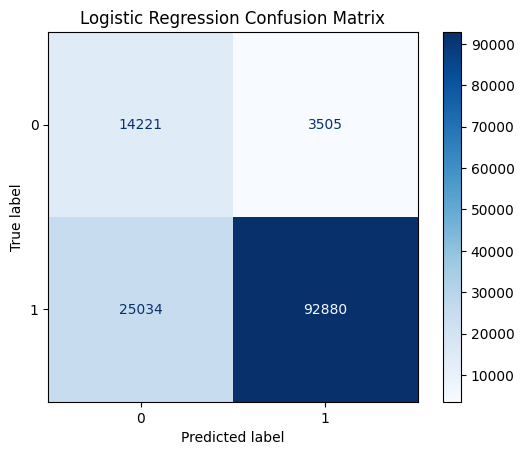

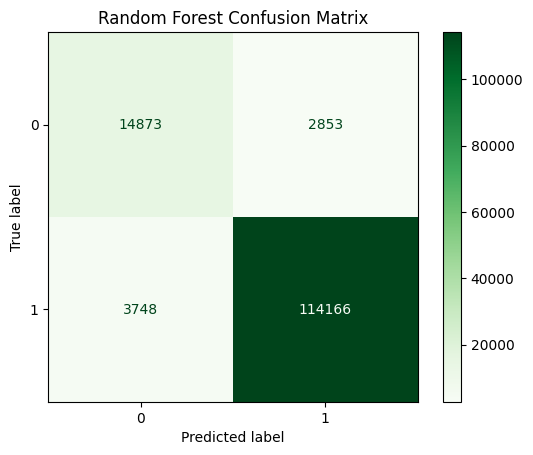

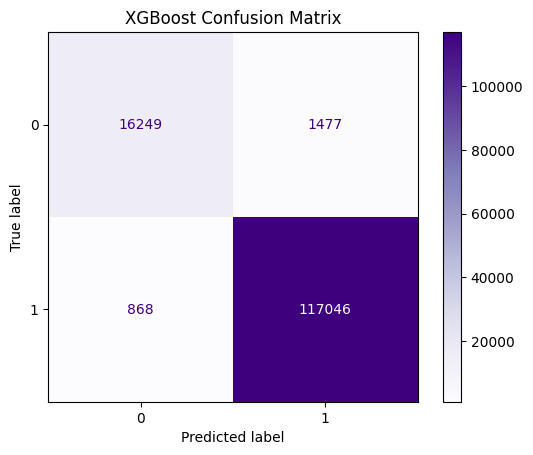

In [39]:
# Logistic Regression
ConfusionMatrixDisplay.from_estimator(random_search_lr.best_estimator_, X_test, y_test, cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# Random Forest
ConfusionMatrixDisplay.from_estimator(random_search_rf.best_estimator_, X_test, y_test, cmap="Greens")
plt.title("Random Forest Confusion Matrix")
plt.show()

# XGBoost
ConfusionMatrixDisplay.from_estimator(random_search_xgb.best_estimator_, X_test, y_test, cmap="Purples")
plt.title("XGBoost Confusion Matrix")
plt.show()

# **17. ROC Curve**

In [41]:
# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, random_search_lr.best_estimator_.predict_proba(X_test)[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})", color="blue")

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, random_search_rf.best_estimator_.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})", color="green")

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, random_search_xgb.best_estimator_.predict_proba(X_test)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.2f})", color="purple")

# Finalizing the plot
plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


NameError: name 'y_prob_lr_best' is not defined

# **18. Precision-Recall Curve**

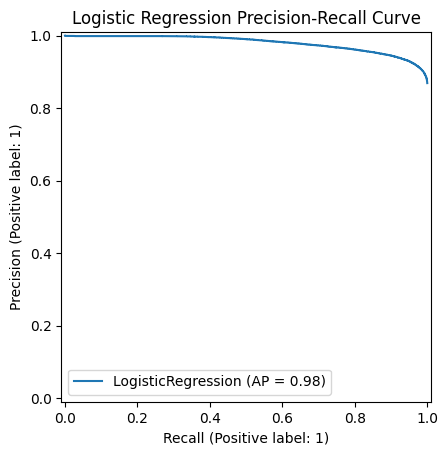

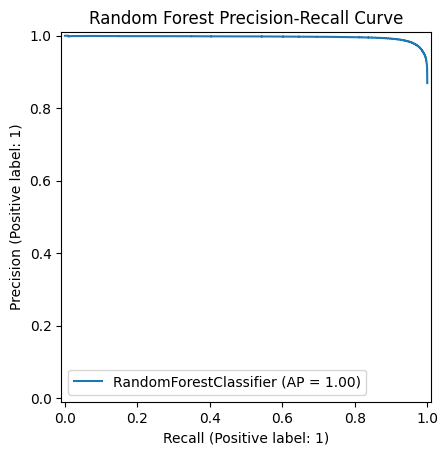

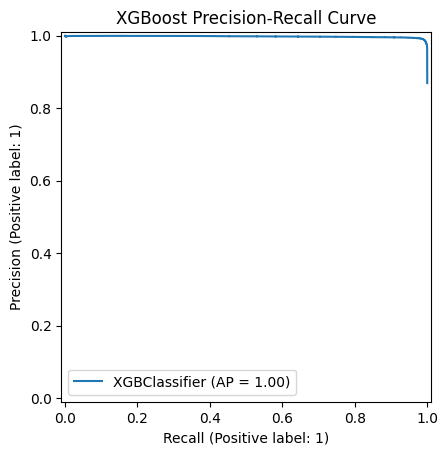

In [42]:
# Logistic Regression
PrecisionRecallDisplay.from_estimator(random_search_lr.best_estimator_, X_test, y_test)
plt.title("Logistic Regression Precision-Recall Curve")
plt.show()

# Random Forest
PrecisionRecallDisplay.from_estimator(random_search_rf.best_estimator_, X_test, y_test)
plt.title("Random Forest Precision-Recall Curve")
plt.show()

# XGBoost
PrecisionRecallDisplay.from_estimator(random_search_xgb.best_estimator_, X_test, y_test)
plt.title("XGBoost Precision-Recall Curve")
plt.show()

# **19. Feature Importance (Tree-Based Models Only)**

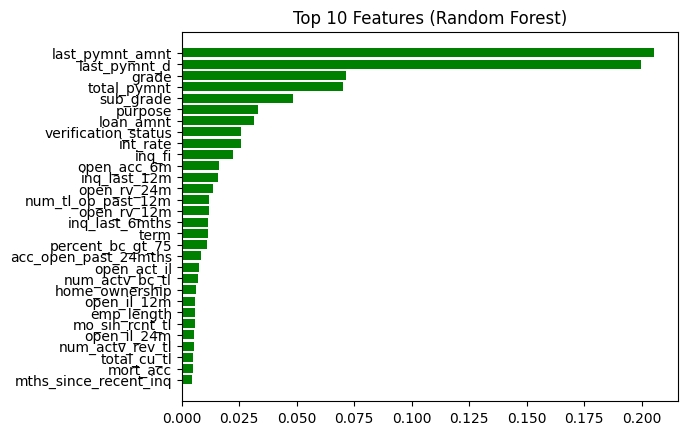

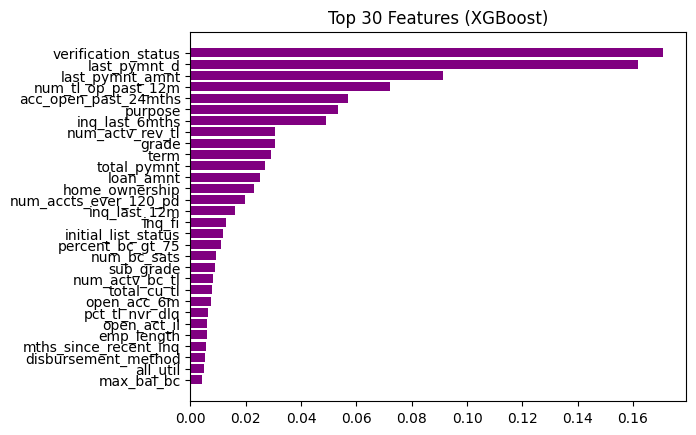

In [44]:
importances_rf = random_search_rf.best_estimator_.feature_importances_
indices_rf = importances_rf.argsort()[-30:]  # Top 30 features
plt.barh(range(len(indices_rf)), importances_rf[indices_rf], color="green", align="center")
plt.yticks(range(len(indices_rf)), [X_train.columns[i] for i in indices_rf])
plt.title("Top 30 Features (Random Forest)")
plt.show()

importances_xgb = random_search_xgb.best_estimator_.feature_importances_
indices_xgb = importances_xgb.argsort()[-30:]  # Top 10 features
plt.barh(range(len(indices_xgb)), importances_xgb[indices_xgb], color="purple", align="center")
plt.yticks(range(len(indices_xgb)), [X_train.columns[i] for i in indices_xgb])
plt.title("Top 30 Features (XGBoost)")
plt.show()

# **20. Model Comparison**

In [ ]:
# Random Forest Feature Importances
importances_rf = random_search_rf.best_estimator_.feature_importances_
indices_rf = importances_rf.argsort()[-30:]  # Top 30 features

# Print Top 30 Random Forest Features
print("\n🔹 Top 30 Features (Random Forest):")
for i in indices_rf:
    print(f"{X_train.columns[i]}: {importances_rf[i]:.4f}")

# Visualize Top 30 Features for Random Forest
plt.barh(range(len(indices_rf)), importances_rf[indices_rf], color="green", align="center")
plt.yticks(range(len(indices_rf)), [X_train.columns[i] for i in indices_rf])
plt.title("Top 30 Features (Random Forest)")
plt.show()

# XGBoost Feature Importances
importances_xgb = random_search_xgb.best_estimator_.feature_importances_
indices_xgb = importances_xgb.argsort()[-30:]  # Top 30 features

# Print Top 30 XGBoost Features
print("\n🔹 Top 30 Features (XGBoost):")
for i in indices_xgb:
    print(f"{X_train.columns[i]}: {importances_xgb[i]:.4f}")

# Visualize Top 30 Features for XGBoost
plt.barh(range(len(indices_xgb)), importances_xgb[indices_xgb], color="purple", align="center")
plt.yticks(range(len(indices_xgb)), [X_train.columns[i] for i in indices_xgb])
plt.title("Top 30 Features (XGBoost)")
plt.show()


In [1]:
# Model names
models = ["Logistic Regression", "Random Forest", "XGBoost"]

# Accuracy scores using best estimators directly
accuracy_scores = [
    accuracy_score(y_test, random_search_lr.best_estimator_.predict(X_test)),
    accuracy_score(y_test, random_search_rf.best_estimator_.predict(X_test)),
    accuracy_score(y_test, random_search_xgb.best_estimator_.predict(X_test))
]

# Create the bar plot
plt.bar(models, accuracy_scores, color=["skyblue", "limegreen", "tomato"])
plt.title("Fig 21: Model Performance Comparison (Accuracy)")
plt.ylabel("Accuracy Score")
plt.ylim(0, 1)  # Ensures consistent scale for scores
plt.show()

NameError: name 'accuracy_score' is not defined